## Get the best runs

In [1]:
import neptune
from misc import save_json
import pandas as pd
import numpy as np
import os
from utils_neptune import start_neptune_run
from paretoset import paretoset
import matplotlib.pyplot as plt
import seaborn as sns


NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [2]:
def pareto_reduction(df, sense_list=None, current_set=None, desired_num=None, objective_cols=None):
    if desired_num is None:
        desired_num = np.floor(0.2*df.shape[0])
    if objective_cols is None:
        objective_cols = df.columns

    if df.shape[0] < desired_num*1.5:
        return df

    mask = paretoset(df[objective_cols], sense=sense_list)
    current_set = pd.concat([current_set, df[mask]])
    if current_set.shape[0] < desired_num:
        return pareto_reduction(df[~mask], sense_list, current_set, desired_num, objective_cols)
    else:
        return current_set

In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1

    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    
    return df_out

In [12]:
encoder_kind = 'AE'
project = neptune.init_project(
    project='revivemed/RCC',
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

runs_table_df = project.fetch_runs_table(tag=['v3.1'],state='inactive').to_pandas()

#drop the failed runs
runs_table_df = runs_table_df[~runs_table_df['sys/failed']].copy()

#filter by encoder_kind
runs_table_df = runs_table_df[runs_table_df['pretrain/kwargs/encoder_kind'] == encoder_kind].copy()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/


Fetching table...: 0 [00:00, ?/s]

In [44]:
cols = ['sys/id']
obj_cols = [col for col in runs_table_df.columns if 'objectives/OBJ' in col]
obj_cols = [col for col in obj_cols if '(v3)' in col]
cols.extend(obj_cols)
df = runs_table_df[cols].copy()
df.set_index('sys/id', inplace=True)
df.columns = [col.split('/')[-1] for col in df.columns]
obj_cols = [col.split('/')[-1] for col in obj_cols]
print(obj_cols)
print('df shape:', df.shape)

['OBJ Adv StudyID (v3)', 'OBJ Gender (v3)', 'OBJ Pediatric (v3)', 'OBJ Recon (v3)']
df shape: (809, 4)


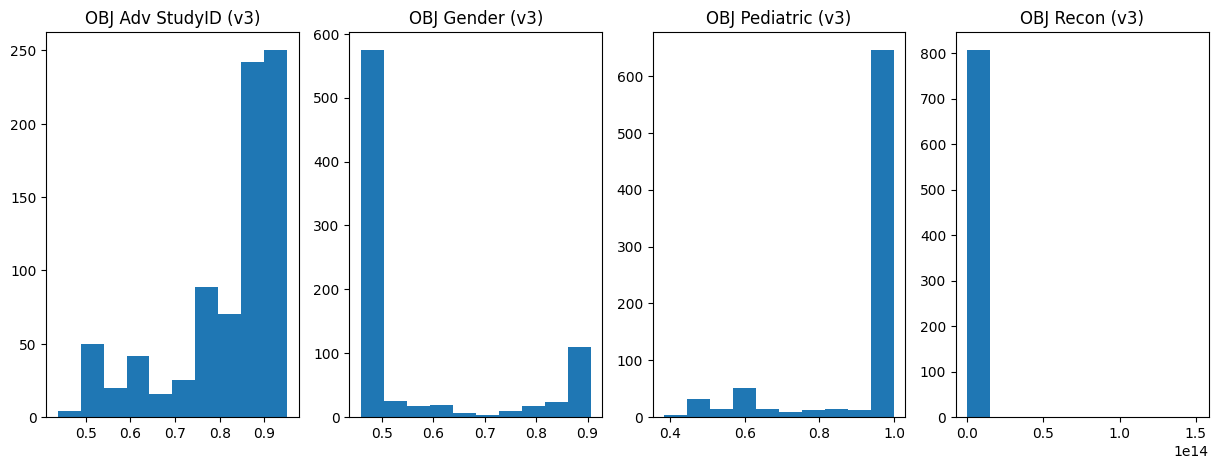

In [45]:
fig, axs = plt.subplots(1, len(df.columns), figsize=(15, 5))

for i, col in enumerate(df.columns):
    axs[i].hist(df[col])
    axs[i].set_title(col)

plt.show()


In [46]:
col = 'OBJ Recon (v3)'
new_col = 'log10 OBJ Recon (v3)'
df[new_col] = np.log10(df[col])
# remove the old column
df.drop(col, axis=1, inplace=True)
objective_cols = [col for col in df.columns if 'OBJ' in col]

In [20]:
# col = 'OBJ Recon (v3)'
# df = remove_outliers(df, col)
# print('df shape:', df.shape)   

# for col in obj_cols:
#     df = remove_outliers(df, col)
# print('df shape:', df.shape)    

df shape: (731, 4)


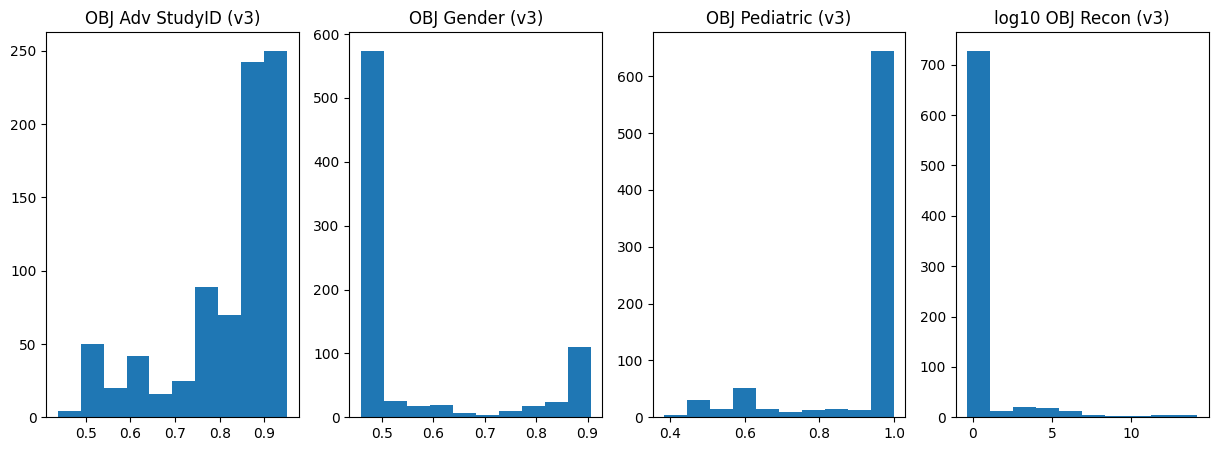

In [26]:
fig, axs = plt.subplots(1, len(df.columns), figsize=(15, 5))

for i, col in enumerate(df.columns):
    axs[i].hist(df[col])
    axs[i].set_title(col)

plt.show()

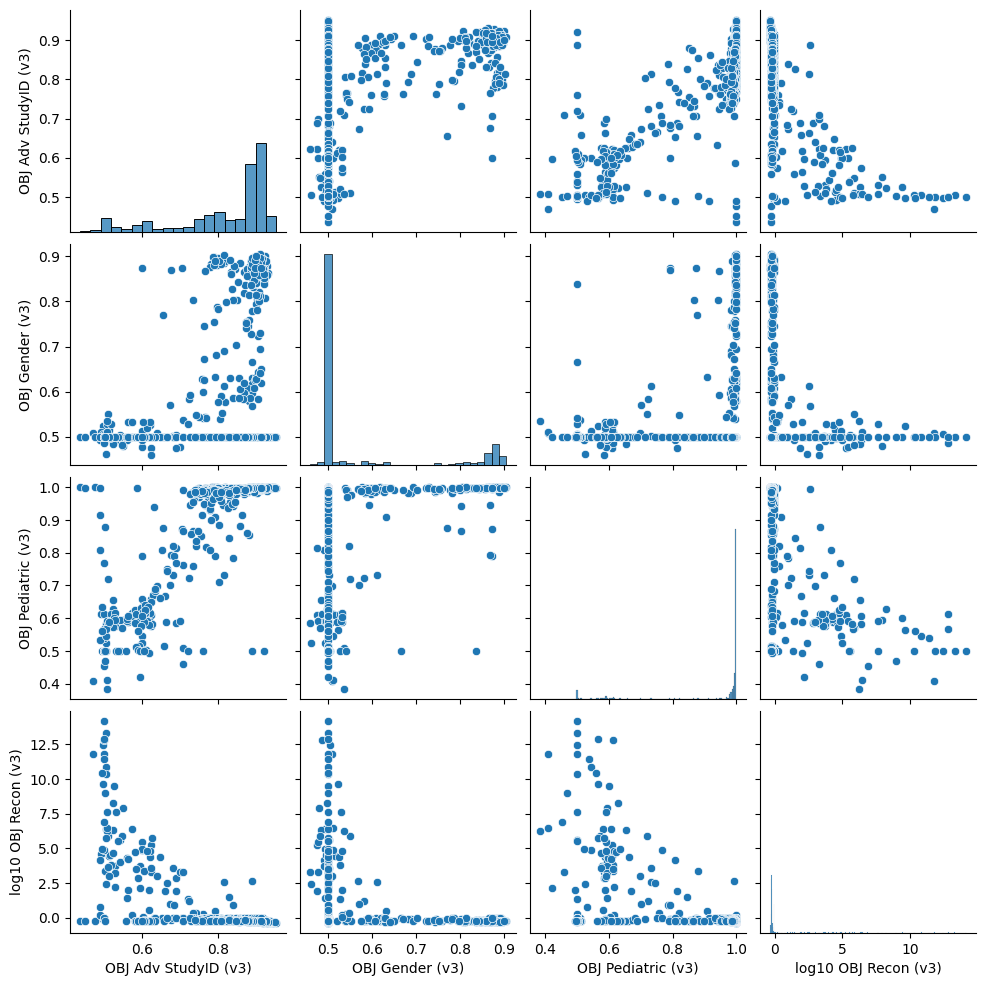

In [27]:
sns.pairplot(df)

In [28]:
df.head()

,OBJ Adv StudyID (v3),OBJ Gender (v3),OBJ Pediatric (v3),log10 OBJ Recon (v3)
sys/id,,,,
RCC-1774,0.904372,0.584420,0.995816,-0.131161
RCC-1773,0.900348,0.882524,0.998903,-0.197099
RCC-1772,0.813239,0.612826,0.733106,2.585859
RCC-1771,0.789046,0.897428,0.999321,-0.204298
RCC-1770,0.886825,0.778232,0.991302,-0.151776


In [47]:
# remove rows with gender below 0.55

df_filtered = df[df['OBJ Gender (v3)'] > 0.50].copy()
print('df shape:', df_filtered.shape)

df shape: (238, 4)


In [53]:
sense_list = ['min','max','max','min']

df_filtered = df_filtered.round(2)
res = pareto_reduction(df_filtered, sense_list=sense_list, desired_num=1, objective_cols=objective_cols)

In [56]:
print('res shape:', res.shape)
res.head()

res shape: (42, 4)


,OBJ Adv StudyID (v3),OBJ Gender (v3),OBJ Pediatric (v3),log10 OBJ Recon (v3)
sys/id,,,,
RCC-1767,0.50,0.52,0.57,9.63
RCC-1764,0.84,0.87,1.00,-0.25
RCC-1763,0.88,0.74,0.98,-0.27
RCC-1759,0.49,0.51,0.61,4.58
RCC-1755,0.79,0.75,0.99,-0.22


In [57]:
df['pareto_front'] = False
df.loc[res.index, 'pareto_front'] = True

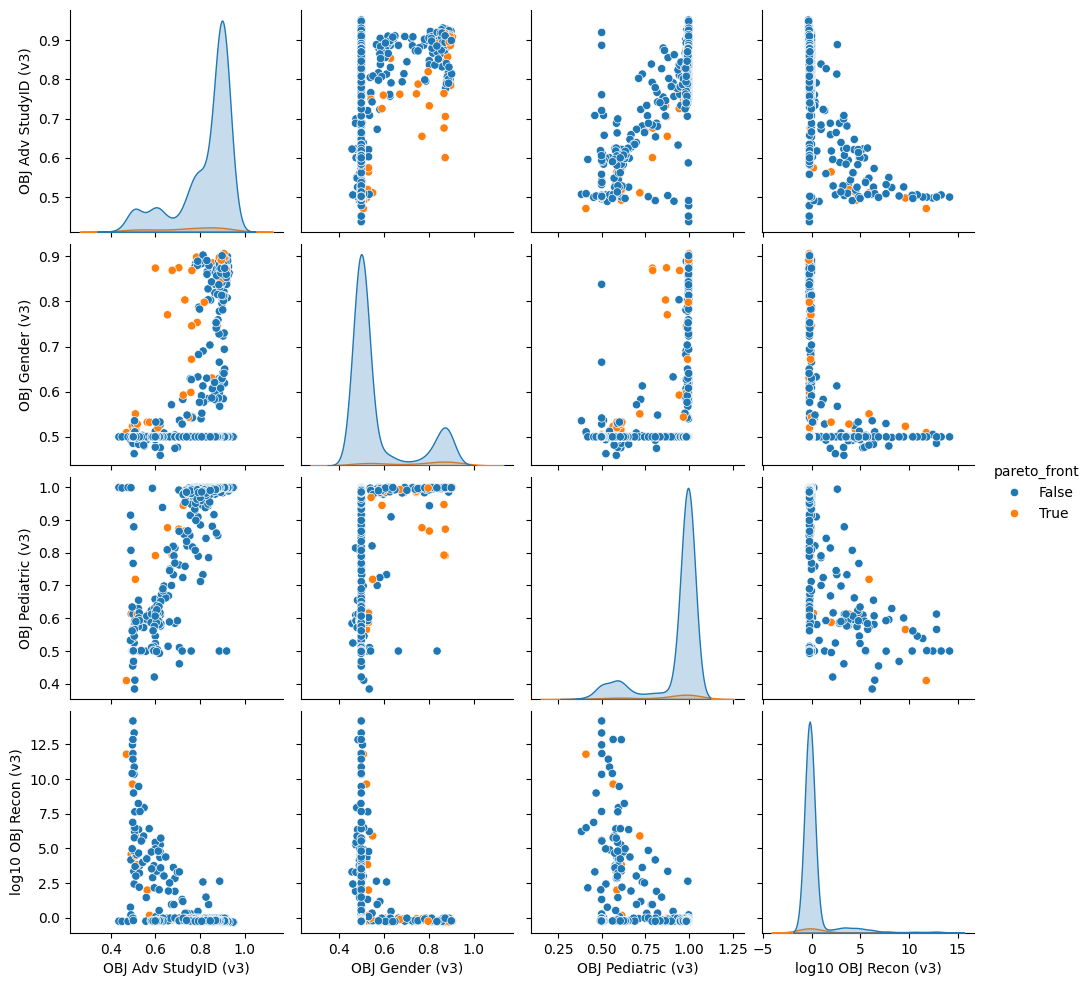

In [58]:
sns.pairplot(df,hue='pareto_front')

In [47]:
# add the tag to the top runs
chosen_runs = res.index.tolist()

for run_id in chosen_runs:
    run, _ = start_neptune_run(with_run_id=run_id)
    run['sys/tags'].add('april04_pareto')
    run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1603
Continuing run: RCC-1603
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-1603/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1601
Continuing run: RCC-1601
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: